In [7]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [17]:
# Import dataset
from google.colab import files
df = files.upload()

Saving fed_funds_rate_with_predictions.csv to fed_funds_rate_with_predictions.csv


In [18]:
df = pd.read_csv('fed_funds_rate_with_predictions.csv')

# Data Exploration
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25692 entries, 0 to 25691
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        25692 non-null  object 
 1   SMA_filled  25692 non-null  float64
dtypes: float64(1), object(1)
memory usage: 401.6+ KB
None
       date  SMA_filled
0  7/1/1954        1.13
1  7/2/1954        1.25
2  7/3/1954        1.25
3  7/4/1954        1.25
4  7/5/1954        0.88


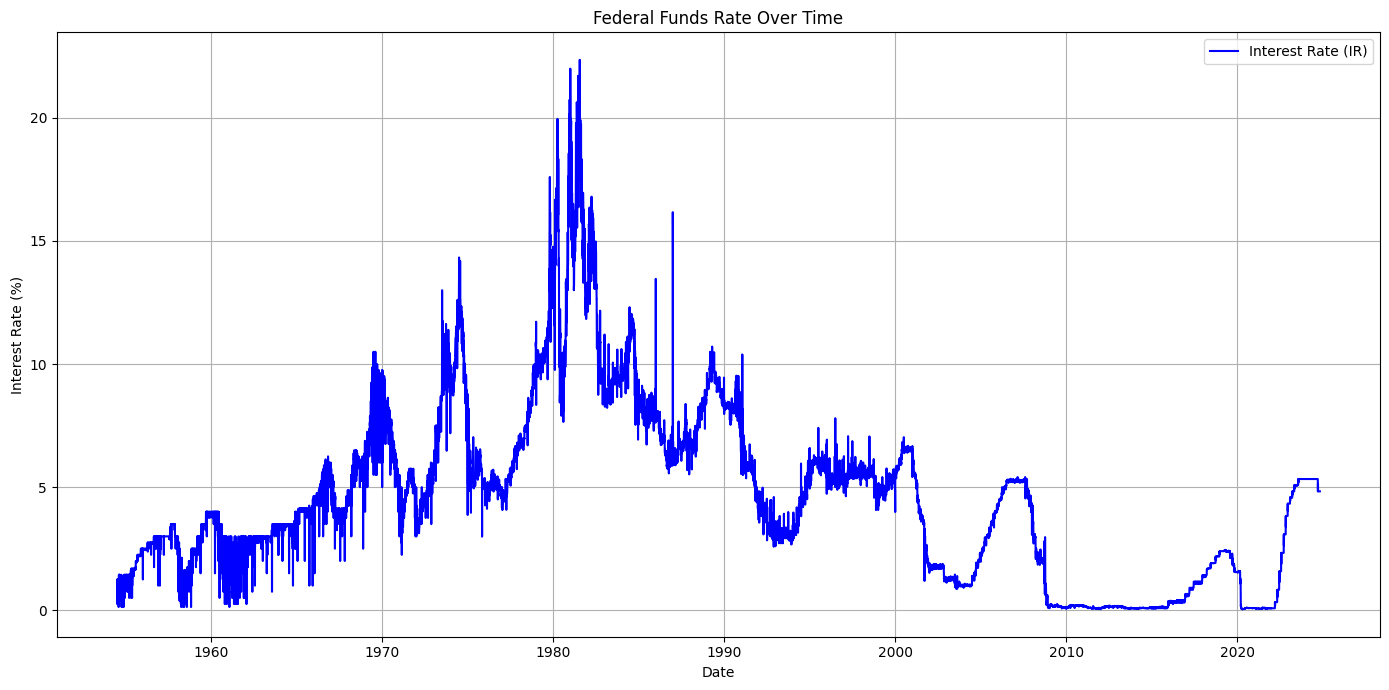

In [19]:
# Ensure 'date' is parsed as a datetime object
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Check for any missing dates (optional)
if df['date'].isnull().sum() > 0:
    print("Warning: Some dates could not be parsed!")

# Plot Interest Rate (IR) over time
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['SMA_filled'], color='blue', label='Interest Rate (IR)')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.title('Federal Funds Rate Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

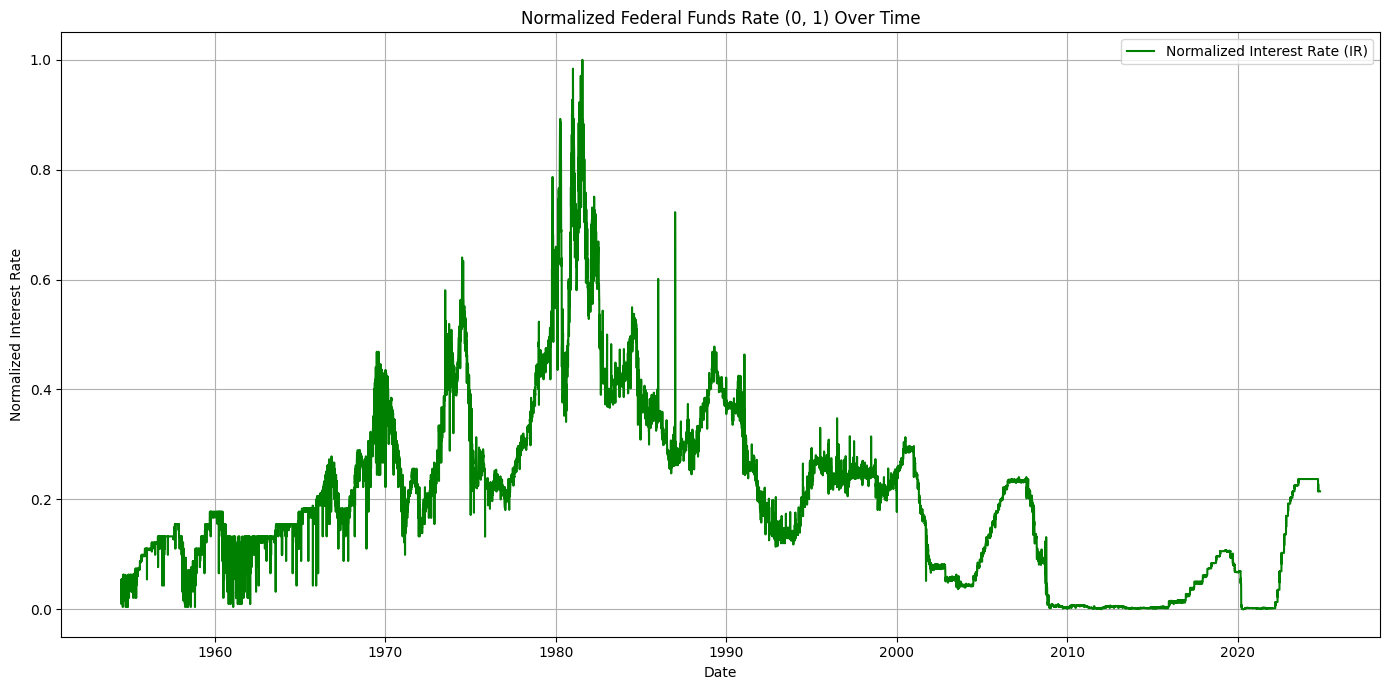

In [20]:
# Min-Max Normalization
min_value = df['SMA_filled'].min()
max_value = df['SMA_filled'].max()
df['SMA_filled_normalized'] = (df['SMA_filled'] - min_value) / (max_value - min_value)

# Plot the normalized Interest Rate (IR) over time
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['SMA_filled_normalized'], color='green', label='Normalized Interest Rate (IR)')
plt.xlabel('Date')
plt.ylabel('Normalized Interest Rate')
plt.title('Normalized Federal Funds Rate (0, 1) Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Implementing GRU

In [8]:
# Function to create sequences
def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Prepare dataset using 'SMA_filled_normalized'
data = df['SMA_filled_normalized'].values
data = data.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences for RNN
window_size = 10  # timestep
X, y = create_sequences(data_scaled, window_size)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X_train and X_test to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the GRU model
model = Sequential()
model.add(GRU(units=20, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(GRU(units=10, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=2, verbose=1)

# Predict using the trained model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform predictions and actual values
train_pred = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))

test_pred = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Evaluation Metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    variance_of_errors = np.var(y_true - y_pred)
    return mse, mae, rmse, r2, variance_of_errors

# Training Metrics
train_mse, train_mae, train_rmse, train_r2, train_var = calculate_metrics(y_train_inv, train_pred)

# Testing Metrics
test_mse, test_mae, test_rmse, test_r2, test_var = calculate_metrics(y_test_inv, test_pred)

# Print Results
print(f"Training Mean Squared Error: {train_mse}")
print(f"Testing Mean Squared Error: {test_mse}")
print(f"Training Mean Absolute Error (MAE): {train_mae}")
print(f"Testing Mean Absolute Error (MAE): {test_mae}")
print(f"Training Root Mean Squared Error (RMSE): {train_rmse}")
print(f"Testing Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Training R-squared (R²): {train_r2}")
print(f"Testing R-squared (R²): {test_r2}")
print(f"Training Variance of Errors: {train_var}")
print(f"Testing Variance of Errors: {test_var}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 136s 13ms/step - loss: 0.0038
Epoch 2/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 117s 11ms/step - loss: 0.0011
Epoch 3/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 148s 12ms/step - loss: 9.9941e-04
Epoch 4/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 134s 11ms/step - loss: 9.7458e-04
Epoch 5/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 144s 11ms/step - loss: 9.8871e-04
Epoch 6/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 0.0010
Epoch 7/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 144s 11ms/step - loss: 9.8068e-04
Epoch 8/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 139s 11ms/step - loss: 9.9889e-04
Epoch 9/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 9.6482e-04
Epoch 10/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 143s 11ms/step - loss: 0.0010
Epoch 11/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 9.3961e-04
Epoch 12/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 116s 11ms/step - loss: 9.8576e-04
Epoch 13/20
10273/10273 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 9.9734e-0

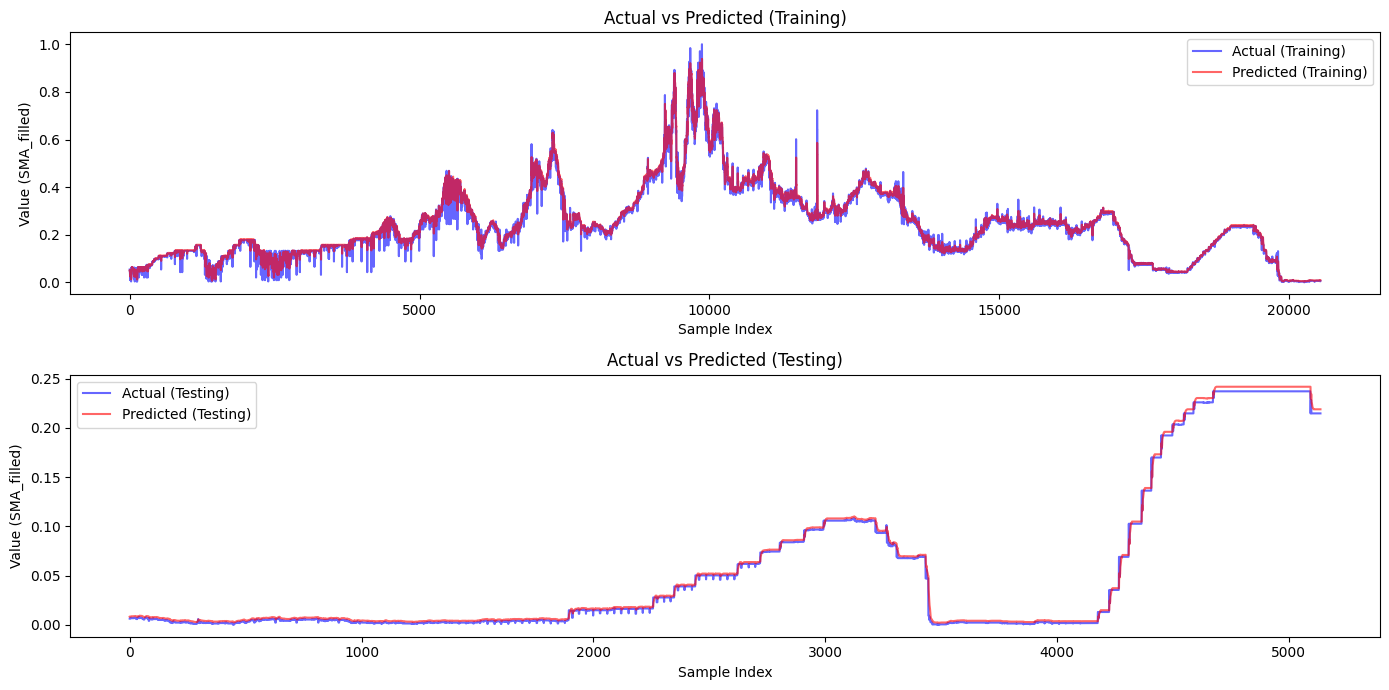

In [9]:
# Plot Actual vs Predicted for Training and Testing Data
plt.figure(figsize=(14, 7))

# Plot for Training Data
plt.subplot(2, 1, 1)
plt.plot(y_train_inv, label='Actual (Training)', color='blue', alpha=0.6)
plt.plot(train_pred, label='Predicted (Training)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

# Plot for Testing Data
plt.subplot(2, 1, 2)
plt.plot(y_test_inv, label='Actual (Testing)', color='blue', alpha=0.6)
plt.plot(test_pred, label='Predicted (Testing)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

plt.tight_layout()
plt.show()

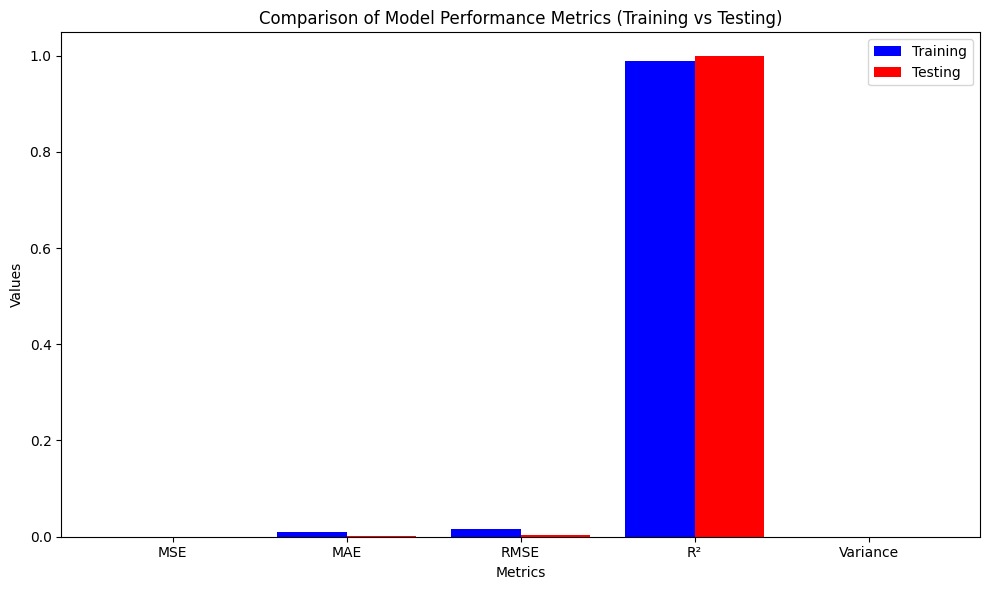

In [10]:
#Bar plot to compare metrics for training and testing sets

metrics = ['MSE', 'MAE', 'RMSE', 'R²', 'Variance']
train_metrics = [train_mse, train_mae, train_rmse, train_r2, train_var]
test_metrics = [test_mse, test_mae, test_rmse, test_r2, test_var]

x = np.arange(len(metrics))

# Plotting comparison of metrics
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_metrics, 0.4, label='Training', color='blue')
plt.bar(x + 0.2, test_metrics, 0.4, label='Testing', color='red')

plt.title('Comparison of Model Performance Metrics (Training vs Testing)')
plt.xticks(x, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
plt.show()

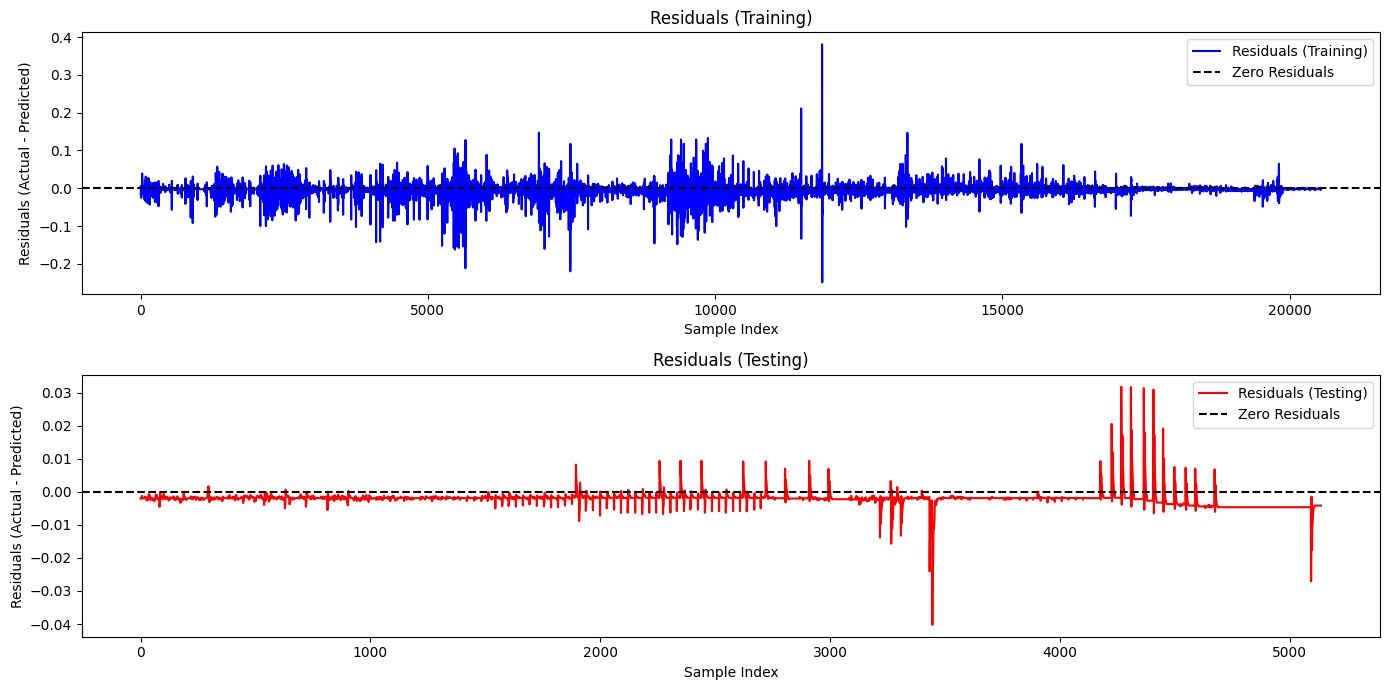

In [11]:
# Calculate residuals
train_errors = y_train_inv.flatten() - train_pred.flatten()
test_errors = y_test_inv.flatten() - test_pred.flatten()

# Residuals Plot (Training and Testing)
plt.figure(figsize=(14, 7))

# Training residuals plot
plt.subplot(2, 1, 1)
plt.plot(train_errors, label='Residuals (Training)', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

# Testing residuals plot
plt.subplot(2, 1, 2)
plt.plot(test_errors, label='Residuals (Testing)', color='red')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

plt.tight_layout()
plt.show()

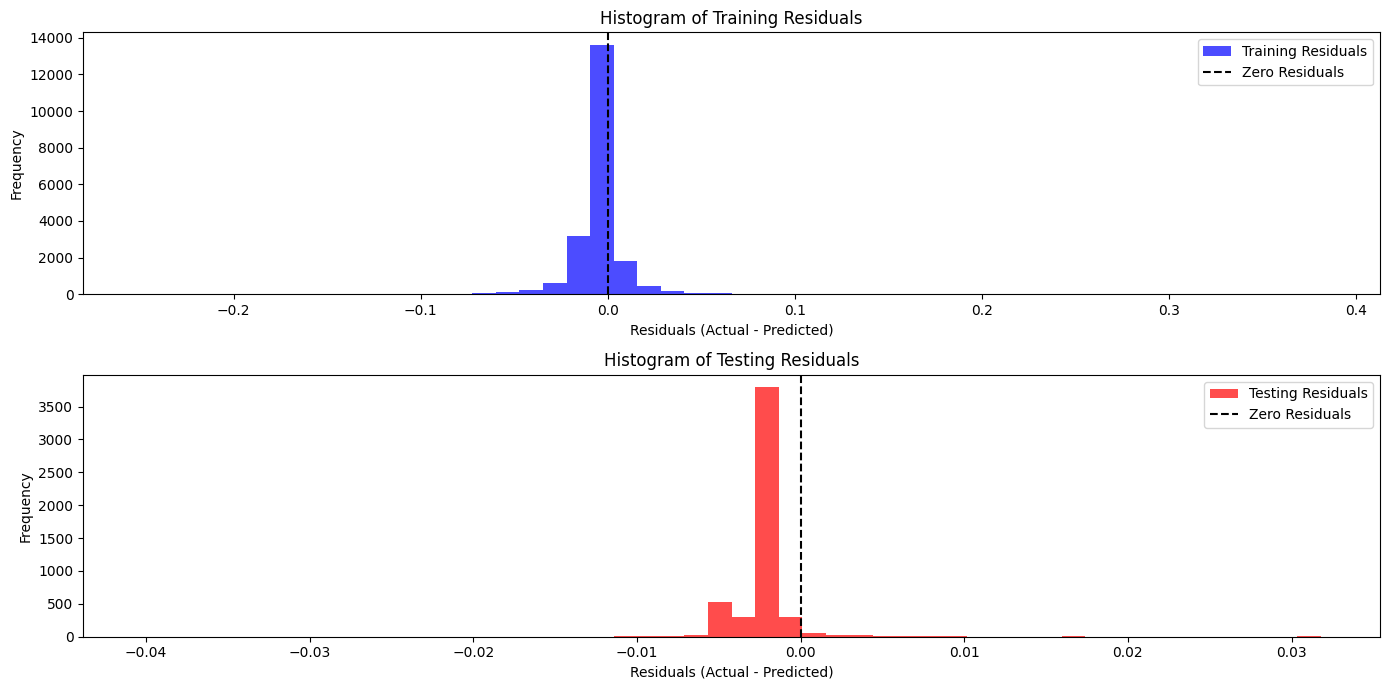

In [12]:
# Calculate residuals
train_errors = y_train_inv.flatten() - train_pred.flatten()
test_errors = y_test_inv.flatten() - test_pred.flatten()

# Histogram of residuals (errors) for training and testing
plt.figure(figsize=(14, 7))

# Training errors histogram
plt.subplot(2, 1, 1)
plt.hist(train_errors, bins=50, color='blue', alpha=0.7, label='Training Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Training Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

# Testing errors histogram
plt.subplot(2, 1, 2)
plt.hist(test_errors, bins=50, color='red', alpha=0.7, label='Testing Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Testing Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Print the model architecture summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 20)              │           1,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,055 (27.56 KB)

 Trainable params: 2,351 (9.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,704 (18.38 KB)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import randint, uniform
import numpy as np

# Define the PyTorch GRU model
class GRUNet(nn.Module):
    def __init__(self, units=20, dropout_rate=0.2):
        super(GRUNet, self).__init__()
        self.gru1 = nn.GRU(input_size=1, hidden_size=units, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(units)

        self.gru2 = nn.GRU(input_size=units, hidden_size=units // 2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate * 2)
        self.bn2 = nn.BatchNorm1d(units // 2)

        self.fc = nn.Linear(units // 2, 1)

    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.dropout1(x[:, -1, :])
        x = self.bn1(x)

        x, _ = self.gru2(x.unsqueeze(1))
        x = self.dropout2(x[:, -1, :])
        x = self.bn2(x)

        x = self.fc(x)
        return x


# Function to train the model
def train_model(X_train, y_train, X_val, y_val, params):
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
    y_val = torch.tensor(y_val, dtype=torch.float32)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    # Initialize model, loss, and optimizer
    model = GRUNet(units=params['units'], dropout_rate=params['dropout_rate'])
    criterion = nn.MSELoss()
    optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])

    # Training loop
    best_val_loss = float('inf')
    patience = 5
    counter = 0

    for epoch in range(params['epochs']):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}: Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model


# Hyperparameter search function
def objective(params):
    global X_train, y_train, X_val, y_val
    model = train_model(X_train, y_train, X_val, y_val, params)
    model.eval()

    X_test_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()

    mse = mean_squared_error(y_val, predictions)
    return mse


# Define hyperparameter grid
param_distributions = {
    'optimizer': ['Adam', 'RMSprop', 'SGD'],
    'units': randint(10, 51),
    'dropout_rate': uniform(0.1, 0.5),
    'batch_size': [2, 4, 8],
    'epochs': randint(10, 51),
    'learning_rate': uniform(0.001, 0.01)
}

# Dummy dataset (replace with actual data)
X = np.random.randn(1000, 10)  # 1000 samples, 10 time steps
y = np.random.randn(1000)

# Train-validation split
X_train, X_val = X[:800], X[800:]
y_train, y_val = y[:800], y[800:]

# Perform RandomizedSearchCV
n_iter = 10
best_score = float('inf')
best_params = None

for params in ParameterSampler(param_distributions, n_iter=n_iter, random_state=42):
    print("Testing params:", params)
    score = objective(params)
    print(f"Validation MSE: {score:.4f}")
    if score < best_score:
        best_score = score
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best Validation MSE:", best_score)

Testing params: {'batch_size': 8, 'dropout_rate': 0.49827149343011645, 'epochs': 24, 'learning_rate': 0.008319939418114052, 'optimizer': 'Adam', 'units': 30}
Epoch 1: Train Loss: 1.0457, Val Loss: 1.3619
Epoch 2: Train Loss: 1.0409, Val Loss: 1.3633
Epoch 3: Train Loss: 1.0377, Val Loss: 1.1369
Epoch 4: Train Loss: 1.0372, Val Loss: 1.1015
Epoch 5: Train Loss: 1.0355, Val Loss: 2.0300
Epoch 6: Train Loss: 1.0348, Val Loss: 1.0968
Epoch 7: Train Loss: 1.0361, Val Loss: 11.9114
Epoch 8: Train Loss: 1.0364, Val Loss: 1.1011
Epoch 9: Train Loss: 1.0349, Val Loss: 15.6277
Epoch 10: Train Loss: 1.0376, Val Loss: 3.8273
Epoch 11: Train Loss: 1.0365, Val Loss: 2.8858
Early stopping triggered.
Validation MSE: 2.8858
Testing params: {'batch_size': 8, 'dropout_rate': 0.3229163764267956, 'epochs': 32, 'learning_rate': 0.0015808361216819947, 'optimizer': 'Adam', 'units': 45}
Epoch 1: Train Loss: 1.2234, Val Loss: 1.1031
Epoch 2: Train Loss: 1.1100, Val Loss: 1.1175
Epoch 3: Train Loss: 1.0573, Val 

Final GRU model:

Best parameters:
Batch_Size: 8
Dropout_rate: 0.1866
Epochs: 26
Learning_rate: 0.003587
Optimizer: RMSprop
Units: 15

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - loss: 0.0833 - val_loss: 0.0016
Epoch 2/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 3/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0049 - val_loss: 1.9739e-04
Epoch 4/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 5/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 0.0047 - val_loss: 0.0083
Epoch 6/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0047 - val_loss: 6.7255e-04
Epoch 7/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0049 - val_loss: 9.7322e-04
Epoch 8/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 9/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0046 - val_loss: 0.0084
Epoch 10/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 11/26
2055/2055 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 0.0044 - val_loss: 0.0

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                         │ (None, 10, 15)              │             810 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 10, 15)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 15)              │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 15)                  │           1,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 15)                  │              60 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,714 (18.42 KB)

 Trainable params: 2,326 (9.09 KB)

 Non-trainable params: 60 (240.00 B)

 Optimizer params: 2,328 (9.10 KB)

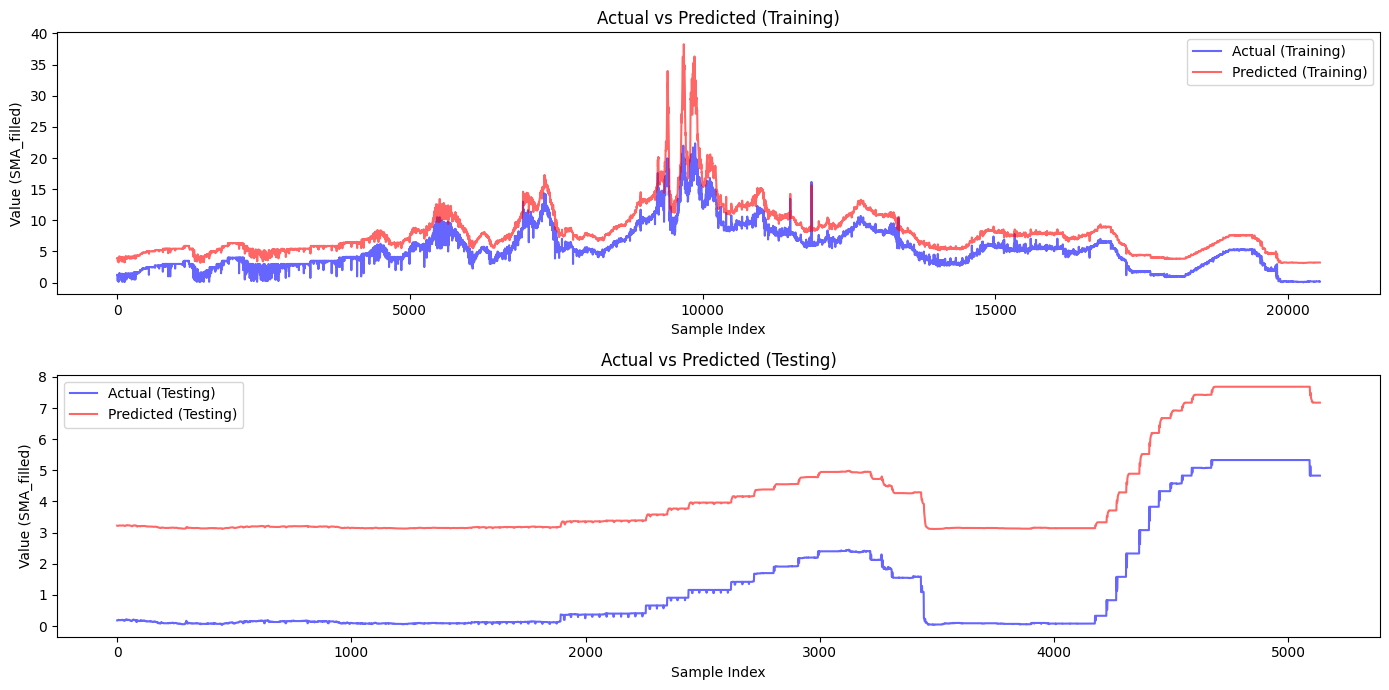

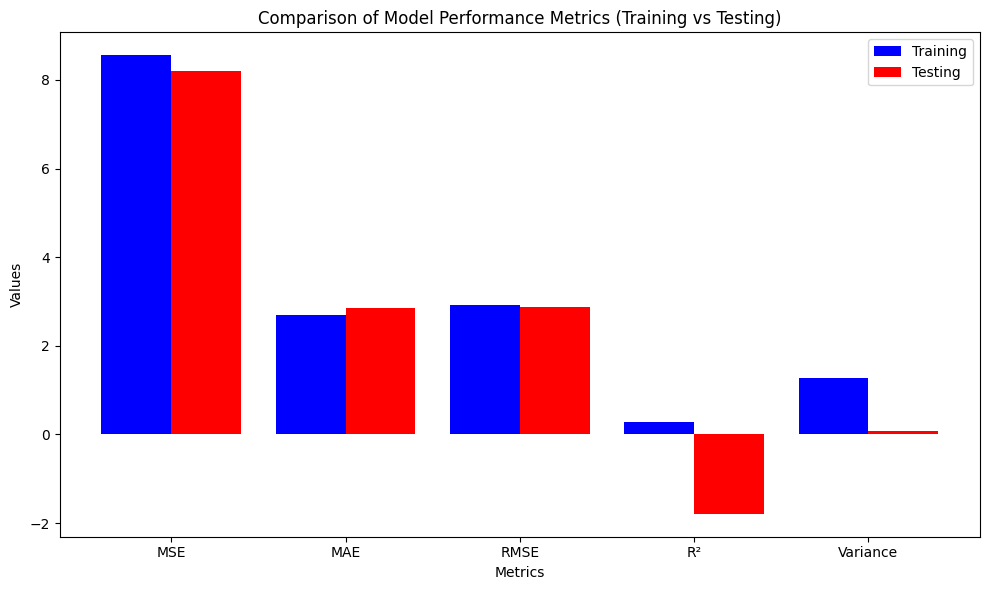

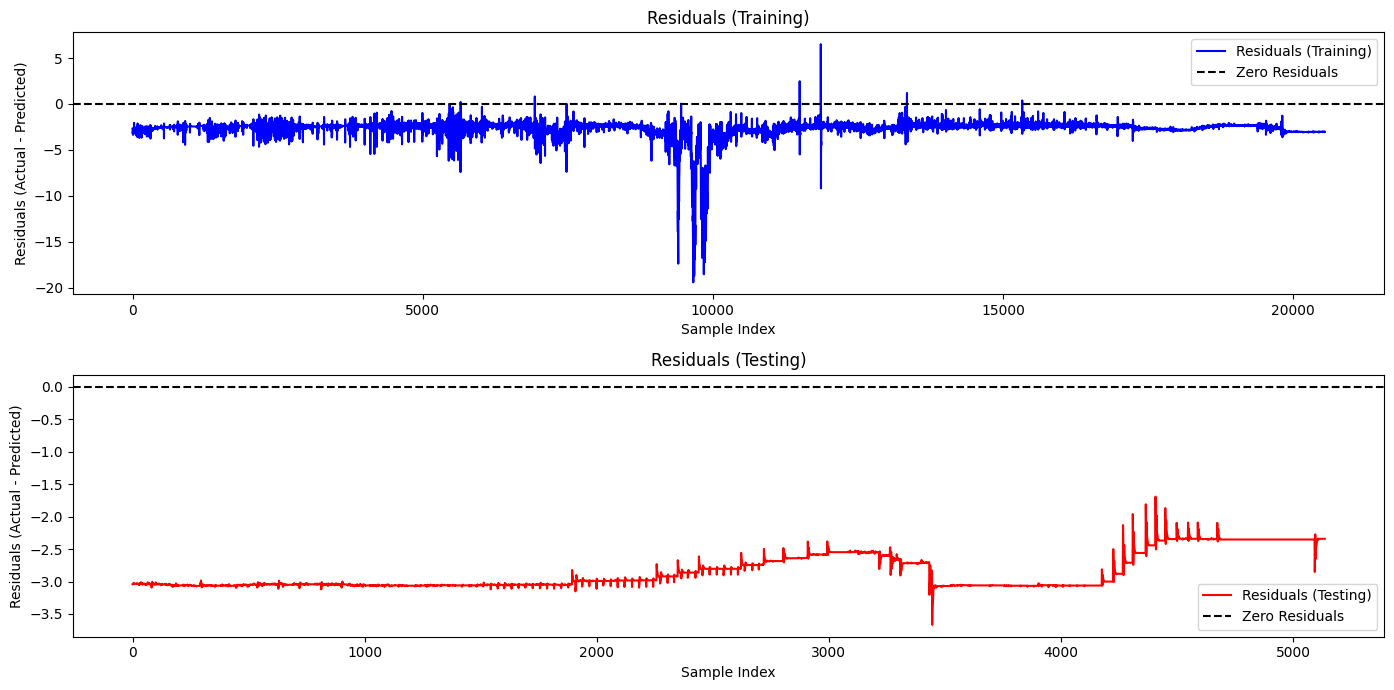

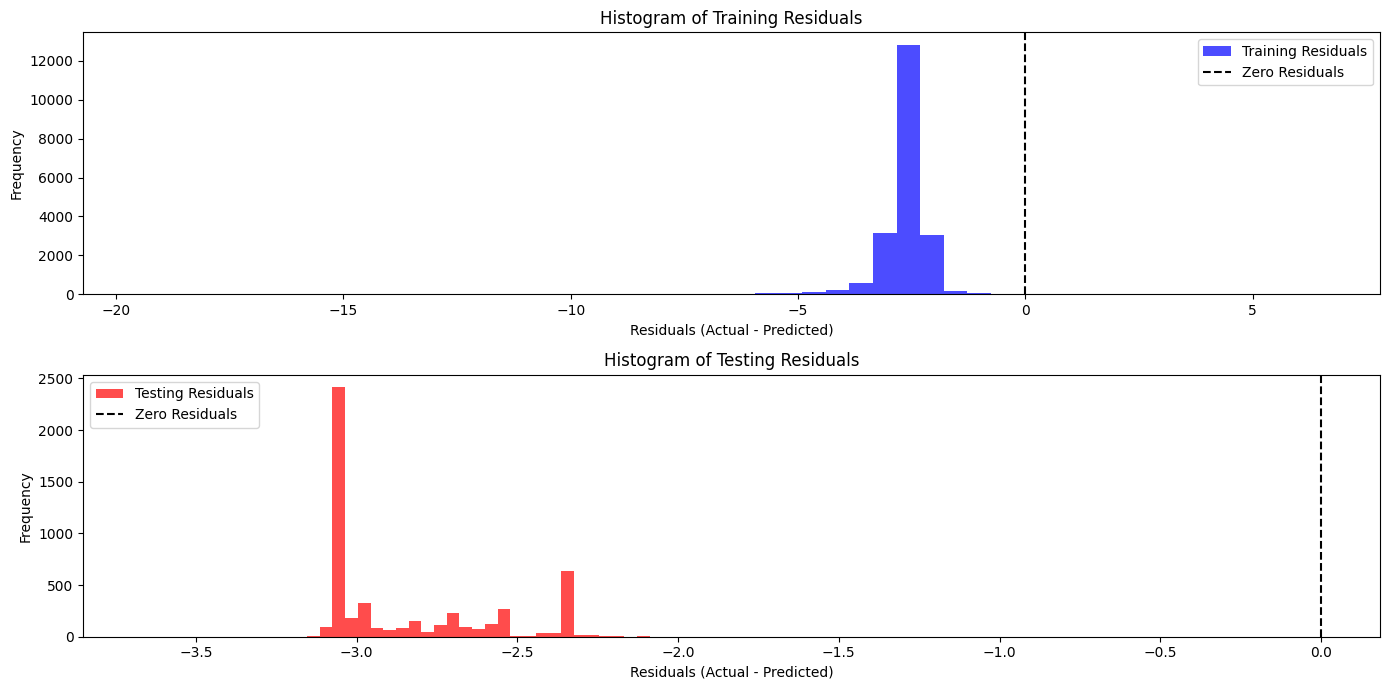

In [21]:
from keras.optimizers import RMSprop
from keras.layers import GRU, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import Dense

# Create sequences for GRU
timesteps = 10  # Define the number of previous values to use for prediction
X = []
y = []

# Create sequences (X) and target values (y)
for i in range(timesteps, len(df)):
    X.append(df['SMA_filled_normalized'][i-timesteps:i].values)
    y.append(df['SMA_filled_normalized'][i])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X_train and X_test into 3D arrays (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the model
model = Sequential()

# GRU layer 1 with dropout and batch normalization
model.add(GRU(units=15, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.18668232675388605))
model.add(BatchNormalization())

# GRU layer 2 with dropout and batch normalization
model.add(GRU(units=15))
model.add(Dropout(0.18668232675388605))
model.add(BatchNormalization())

# Output layer
model.add(Dense(units=1))

# Compile the model with optimizer and loss function
optimizer = RMSprop(learning_rate=0.0035877998160001694)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model (no early stopping)
model.fit(X_train, y_train, epochs=26, batch_size=8, verbose=1, validation_split=0.2)

# Predict using the trained model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Reshape predictions to 2D for inverse transformation
train_pred = train_pred.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)

# Inverse transform predictions and actual values to get them back to the original scale
scaler = MinMaxScaler()
scaler.fit(df['SMA_filled'].values.reshape(-1, 1))
train_pred = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error (MSE)
train_mse = mean_squared_error(y_train_inv, train_pred)
test_mse = mean_squared_error(y_test_inv, test_pred)

# Calculate Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_inv, train_pred)
test_mae = mean_absolute_error(y_test_inv, test_pred)

# Calculate Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate R-squared (R²)
train_r2 = r2_score(y_train_inv, train_pred)
test_r2 = r2_score(y_test_inv, test_pred)

# Calculate Variance of the errors (Residuals)
train_variance = np.var(y_train_inv - train_pred)
test_variance = np.var(y_test_inv - test_pred)

# Print metrics
print(f'Training Mean Squared Error: {train_mse}')
print(f'Testing Mean Squared Error: {test_mse}')
print(f'Training Mean Absolute Error (MAE): {train_mae}')
print(f'Testing Mean Absolute Error (MAE): {test_mae}')
print(f'Training Root Mean Squared Error (RMSE): {train_rmse}')
print(f'Testing Root Mean Squared Error (RMSE): {test_rmse}')
print(f'Training R-squared (R²): {train_r2}')
print(f'Testing R-squared (R²): {test_r2}')
print(f'Training Variance of Errors: {train_variance}')
print(f'Testing Variance of Errors: {test_variance}')

# Print the model architecture summary
model.summary()

# Plot Actual vs Predicted for Training and Testing Data
plt.figure(figsize=(14, 7))

# Plot for Training Data
plt.subplot(2, 1, 1)
plt.plot(y_train_inv, label='Actual (Training)', color='blue', alpha=0.6)
plt.plot(train_pred, label='Predicted (Training)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

# Plot for Testing Data
plt.subplot(2, 1, 2)
plt.plot(y_test_inv, label='Actual (Testing)', color='blue', alpha=0.6)
plt.plot(test_pred, label='Predicted (Testing)', color='red', alpha=0.6)
plt.title('Actual vs Predicted (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Value (SMA_filled)')
plt.legend()

plt.tight_layout()
plt.show()

# Bar plot to compare metrics for training and testing sets

metrics = ['MSE', 'MAE', 'RMSE', 'R²', 'Variance']
train_metrics = [train_mse, train_mae, train_rmse, train_r2, train_variance]
test_metrics = [test_mse, test_mae, test_rmse, test_r2, test_variance]

x = np.arange(len(metrics))  # X-axis positions

# Plotting comparison of metrics
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, train_metrics, 0.4, label='Training', color='blue')
plt.bar(x + 0.2, test_metrics, 0.4, label='Testing', color='red')

plt.title('Comparison of Model Performance Metrics (Training vs Testing)')
plt.xticks(x, metrics)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate residuals
train_errors = y_train_inv.flatten() - train_pred.flatten()
test_errors = y_test_inv.flatten() - test_pred.flatten()

# Residuals Plot (Training and Testing)
plt.figure(figsize=(14, 7))

# Training residuals plot
plt.subplot(2, 1, 1)
plt.plot(train_errors, label='Residuals (Training)', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Training)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

# Testing residuals plot
plt.subplot(2, 1, 2)
plt.plot(test_errors, label='Residuals (Testing)', color='red')
plt.axhline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Residuals (Testing)')
plt.xlabel('Sample Index')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()

plt.tight_layout()
plt.show()

# Histogram of residuals (errors) for training and testing
plt.figure(figsize=(14, 7))

# Training errors histogram
plt.subplot(2, 1, 1)
plt.hist(train_errors, bins=50, color='blue', alpha=0.7, label='Training Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Training Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

# Testing errors histogram
plt.subplot(2, 1, 2)
plt.hist(test_errors, bins=50, color='red', alpha=0.7, label='Testing Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residuals')
plt.title('Histogram of Testing Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()